# The HFM library - A fast marching solver with adaptive stencils

## Part : Non holonomic metrics and curvature penalization
## Chapter : Curvature penalized planar paths.

In this notebook, we demonstrate the computation of globally optimal curvature penalized minimal paths, as described in the paper:

<a name="cite_Mir17c"> [Mir17c]</a>	J.-M. Mirebeau, “Fast Marching methods for Curvature Penalized Shortest Paths,” JMIV. 2018. [link](https://hal.archives-ouvertes.fr/hal-01538482)

More precisely, to each path $x : [0,T] \to {\mathbb R}^2$, parametrized at *unit euclidean speed*, we attach a cost of the form
\begin{equation*}
\mathcal E(x(\cdot)) = \int_0^T c(x(t),x'(t)) \, {\mathcal C}( \|x''(t)\| ) \, \mathrm d t.
\end{equation*}
The integrated path cost is the product of two factors: a first term $c(x,\dot x)$ depending on the current position and orientation, and a second term ${\mathcal C}(\|\ddot x\|)$ depending on the curvature. 
Recall, indeed, that for a path parametrized at unit euclidean speed, acceleration is curvature.

The first term $c : \mathbb R^2 \times \mathbb S^1 \to ]0,\infty[$ is arbitrary and provided by the user. 
The second must be chosen among the following cost functions $\mathcal C(\kappa)$

Model name | Reeds-Shepp | Euler-Mumford elastica| Dubins car
--- | :---: | :---: | :---:
$\mathcal C(\kappa)$ | $\sqrt{1+(\xi\kappa)^2}$ | $1+(\xi\kappa)^2$ | $\begin{cases} 1 & |\xi\kappa| \leq 1 \\ \infty & \text{else} \end{cases}$

The parameter $\xi>0$ has the dimension of a radius of curvature, and is chosen by the user. (It is unrelated with the similarly named parameter appearing in the discussion of sensitivity analysis.)
The Reeds-Shepp, Euler-Mumford elastica, and Dubins car costs penalize large curvatures in an increasingly strong manner: respectively (approximately) linear, quadratic, and absolute (the path is rejected).

The Reeds-Shepp cost is used to define two distinct models, referred to as *Reeds-Shepp* (the classical, sub-riemannian model), and *Reeds-Shepp forward*. In the former case, the car may shift into reverse gear, which introduces *cusp points* where the path orientation is reversed. This behaviour is forbidden in the *Reeds-Shepp forward* model, as well as in the Euler-Mumford elastica and the Dubins car models.

Consider a two dimensional domain $U \subset \mathbb R^2$, and some initial and final points $x_*,x^* \in U$, and tangents $n_*, n^* \in \mathbb S^1$. 
The HFM software is able to find the path $x : [0,T] \to U$, parametrized at unit speed and where the terminal time $T$ is free, obeying the prescribed constraints and globally minimizing the cost $\mathcal E(x(\cdot))$. In other words it solves
\begin{align*}
&\min_{T,c} \mathcal E(x()) &\text{ subject to } \ x:[0,T] \to U,\, x(0)=x_*,\ x'(0)=n_*,\ x(T)=x^*,\ x'(T)=n^*, \text{ and }\forall t, \|x'(t)\|=1.
\end{align*}

<!--
* Standard models.
* Projective model.
* Asymmetric models.
-->



[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Defining the domain](#1.-Defining-the-domain)
  * [2. Specifying the metric](#2.-Specifying-the-metric)
  * [3. Calling the software, and displaying the results.](#3.-Calling-the-software,-and-displaying-the-results.)
  * [4. Comparison of the different models.](#4.-Comparison-of-the-different-models.)
    * [4.1 The Reeds-Shepp car (with reverse gear)](#4.1-The-Reeds-Shepp-car-(with-reverse-gear))
    * [4.2 The Reeds-Shepp forward model (without reverse gear)](#4.2-The-Reeds-Shepp-forward-model-(without-reverse-gear))
    * [4.3 Euler-Mumford elastica curves](#4.3-Euler-Mumford-elastica-curves)
    * [4.4 The Dubins car](#4.4-The-Dubins-car)
  * [5. Varying the cost function](#5.-Varying-the-cost-function)
    * [5.1 Cost depending on the physical position](#5.1-Cost-depending-on-the-physical-position)
    * [5.2 Orientation dependent speed](#5.2-Orientation-dependent-speed)
  * [6. Generalized models with non-uniform curvature penalization](#6.-Generalized-models-with-non-uniform-curvature-penalization)
    * [6.1 Position dependent radius of curvature](#6.1-Position-dependent-radius-of-curvature)
    * [6.2 Distinct bound on the radius of curvature for right and left turns.](#6.2-Distinct-bound-on-the-radius-of-curvature-for-right-and-left-turns.)
  * [7. Additional functionality](#7.-Additional-functionality)
    * [7.1 Euclidean length of geodesics](#7.1-Euclidean-length-of-geodesics)
    * [7.2 Minimal geodesic joining two seeds.](#7.2-Minimal-geodesic-joining-two-seeds.)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

In [1]:
eikonal_mode = 'gpu'

## 0. Importing the required libraries

In [2]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Curvature','FMM'))

In [3]:
from agd import Eikonal
from agd import AutomaticDifferentiation as ad
from agd.Plotting import savefig, SetTitle3D; #savefig.dirName = 'Figures/Curvature/'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Plots 3D paths

useMayavi = False
if useMayavi:
    from mayavi import mlab # Plots implicit surfaces

In [5]:
def SetDevice():
    global xp,plt
    if eikonal_mode == 'cpu': xp = np
    else:
        import cupy
        xp = ad.functional.decorate_module_functions(cupy,ad.cupy_generic.set_output_dtype32) 
        plt = ad.functional.decorate_module_functions(plt,ad.cupy_generic.cupy_get_args)
        Eikonal.dictIn.default_mode = eikonal_mode
        ad.array.caster = lambda x:cupy.asarray(x,dtype=np.float32)
SetDevice()

## 1. Defining the domain

In order to compute paths minimizing curvature dependent energies, we use a technique referred to as dimension lifting. It involves the three dimensional product domain 
\begin{equation*}
\Omega := U \times \mathbb S^1
\end{equation*}
where $U \subset \mathbb R^2$ is the physical domain, and $\mathbb S^1 = [0,2\pi[$ is the angular domain, with periodic boundary conditions. The HFM software extracts a three dimensional path $\gamma : [0,T] \to U \times \mathbb S^1$, featuring directional information 
\begin{equation*}
\gamma(t) = (x(t), \theta(t)).
\end{equation*}
The physical velocity and the angular orientation are tied by the relation
where $x'(t) = \|x'(t)\| (\cos \theta(t), \sin \theta(t))$. In the case of the Reeds Shepp model, which has a reverse gear, the constraint is relaxed into $x'(t) = \pm \|x'(t)\| (\cos \theta(t), \sin \theta(t))$.


The physical domain $U$ is discretized using a cartesian grid, which dimensions, origin, a spacing are specified similarly to the Isotropic and Riemannian models.

For the angular domain use a uniform sampling $\{0,h_\theta, \cdots, (n_\theta-1) h_\theta\}\subset [0,2 \pi[$ is used, where $n_\theta$ is the number of discretization points and $h_\theta := 2\pi/n_\theta$ is the corresponding angular resolution. We often use $n_\theta = 60$, and in general we suggest choosing $60 \lesssim n_\theta \lesssim 120$.

In [6]:
# Define the physical domain, by specifying (bottom,left) and (top,right) corners
n = 100; nTheta=60
hfmIn = Eikonal.dictIn({'model':'Elastica2'}) # Has (position , orientation) domain
hfmIn.SetRect(sides=[[-1,1],[0,1]],gridScale=1./n) # Position space
hfmIn.nTheta=nTheta # Angular domain sampling

Let us insert in the domain some seeds, from which the front is propagated, and tips, from which geodesics are backtracked. Seeds $p_* = (x_*,\theta_*)$ and tips $p^*=(x^*,\theta^*)$ are elements of the three dimensional product space $\Omega = U \times \mathbb S^1$.

We also offer the possibility to introduce some "unoriented seeds" $x_*\in U$, from which the front is propagated in all directions $(x_*,\theta)$, $\theta \in \mathbb S^1$. "Unoriented tips" $x^*\in U$ can also be specified, in which case the shortest geodesic is returned, among all those starting from $(x^*,\theta)$, $\theta \in \mathbb S^1$.

In [7]:
hfmIn.update({
    # Declare the seeds, from which the front is propagated
    'seed':[-0.5,0.5,0],
    'seed_Unoriented':[0.5,0.5],
    
    # Optionally declare the boundary conditions at the seeds (default is 0)
    'seedValue':0.,
    'seedValue_Unoriented':0.3,
})

# Declare the tips, from which the geodesics are backtracked
hfmIn['tips'] = [[x,y,np.pi/4] 
                for x in Eikonal.CenteredLinspace(-1,1,6) 
                for y in Eikonal.CenteredLinspace(0,1,4)]
hfmIn['tips_Unoriented'] = hfmIn['tips'][:,0:2] 

<a name="coords"></a>
Finally, we construct a coordinate system, for constructing the synthetic data used in our examples. Actually, we build two: First, a three dimensional coordinate system, as could be expected. Second, a system adapted to the construction of fields depending only on the position, or only on the orientation. The latter one is enough for many examples, and somewhat reduces the memory usage. 


Let us immediately ackowledge a potential conflict of notations: the letter $x$ refers to a point of the physical domain in the mathematical paragraphs. However, in the python codes, the capital letters X and Y refer to the horizontal and vertical coordinates in the physical domain.

In [8]:
# Genuine three dimensional coordinate system.
X,Y,Theta = hfmIn.Grid()

# System built of two dimensional arrays X2,Y2, and of a one dimensional array Theta2
X2,Y2 = X[:,:,0], Y[:,:,0]
Theta2 = Theta[0,0,:]

## 2. Specifying the metric

In this paragraph, we briefly expose how the computation of curvature penalized minimal paths is addressed using fast marching techniques, although this is not strictly necessary for using the HFM software. Our objective is to minimize a second order energy $\mathcal E(x(\cdot))$, where $x : [0,T] \to U$ is a planar path. For that purpose, this energy is encoded as the path length $L_F(\gamma)$ of a [lifted path](#sec_domain) $\gamma : [0,T] \to \Omega = U \times \mathbb S^1$. The metric $F$, which is singular, is defined in the next paragraph.


We introduce a metric $F$ on the tangent space to the lifted domain. For any point $p = (x,\theta) \in \Omega$ and any tangent vector $\dot p = (\dot x, \dot \theta) \in \mathbb R^2 \times \mathbb R$ with unit physical speed $\|\dot x\| = 1$, it is defined by 
\begin{equation*}
F_{(x,\theta)}(\dot x, \dot \theta) = c(x,\theta)
\begin{cases}
\mathcal C(\dot \theta) & \text{ if } \dot x = (\cos \theta, \sin \theta),\\
+\infty & \text{ else}.
\end{cases}
\end{equation*}
The colinearity constraint is changed into $\dot x = \pm (\cos \theta, \sin \theta)$ is the case of the classical Reeds-Shepp model, which has a reverse gear.
We extend the metric by $1$-homogeneity: $F_p(\lambda \dot p) = \lambda F_p(\dot p)$, $\lambda >0$, in the case $\|\dot x\| \neq 1$ of a non-unit physical speed. Thanks to this, the length of a path, as measured by the metric $F$ is parametrization invariant.

Denote by $u(p)$, where $p = (x,\theta) \in \Omega$ is a point of the lifted domain, the minimal length of a path $\gamma:[0,1] \to \overline \Omega$ from $\partial \Omega$ to $p$. Length is measured using the metric $F$, and takes into account the boundary conditions $\sigma : \partial \Omega \to ]-\infty,\infty]$
\begin{equation*}
u(p) := \min_{\substack{\gamma(0) \in \partial \Omega\\ \gamma(1)=p}} \sigma(\gamma(0)) + \int_0^1 F_{\gamma(t)}(\gamma'(t))\, \mathrm dt.
\end{equation*}
Then, under general assumptions, and similarly to the Isotropic and the Riemannian case, the arrival times $u : \overline \Omega \to ]-\infty,\infty]$ are weak solutions to the generalized eikonal PDE 
\begin{align*}
\forall p \in \Omega, F^*_p(\nabla u(p)) &= 1, &
\forall p \in \partial \Omega, u(p) = \sigma(p).
\end{align*}
The dual metric, involved in this equation, is defined at any point $p \in \Omega$ and for any co-tangent vector  $\hat p\in R^2 \times \mathbb R$ by
\begin{equation*}
F_p^*(\hat p) := \sup \{ \hat p \cdot \dot p;\, \dot p \in R^2 \times \mathbb R, F_p(\dot p) \leq 1\}.
\end{equation*}


The HFM software numerically solves the generalized eikonal equation above, using a finite differences approximation of the quantity $F_p^*(\nabla u(p))$. The explicit expression of the dual metric $F_p^*(\nabla u(p))$, and the design of the discretization scheme, are described in [Mir17c](#cite_Mire17c) and in the IPOL submission. 

Our PDE discretization actually depends on a small parameter $\varepsilon>0$, which reflects the relaxation of the non-holonomy constraint (In the Euler-Mumford elastica case there is also a integer parameter $K$ related to a quadrature formula). The default values $\varepsilon = 0.1$ and $K=5$ are suitable for many applications, and we recommend not changing them unless one knows what he is doing. Let us nevertheless mention that:
* reducing the value of $\varepsilon$ enforces better the non-holonomy constraint, but a proportional increase in the physical and angular resolution is required.
* using a larger $K$ may slightly enhance the accuracy of the Euler-Mumford discretization, but it increases the computational cost.

In [9]:
# Select the model. Possible choices are : 
# * ReedsShepp2 - the classical Reeds-Shepp model with reverse gear
# * ReedsSheppForward2 - likewise but without reverse gear
# * Elastica2 - Euler-Mumford elastica, with quadrature parameter K=5. (Elastica2<9> is also implemented.)
# * Dubins2 - Dubins car model
hfmIn['model'] = 'Elastica2'

# Choose the reference radius of curvature 
hfmIn['xi'] = 0.2

# Optionally, choose the relaxation parameter related with the non-holonomy constraint (default is 0.1)
#hfmInput['eps'] = 0.15 

The cost function $c$ defined on $\Omega = U \times \mathbb S^1$, may depend on both the physical coordinate $x \in U$ and the angular coordinate $\theta \in \mathbb S^1$. It may also be a constant, or depend on the physical coordinate only, or the angular coordinate only. 

The systems of coordinates (X,Y,Theta), and the sub-systems (X2,Y2) and Theta2 were built [here](#coords). Recall that the capital letters X and Y, or X2 and Y2, refer to the coordinates of the physical point $x \in U$.

In [10]:
# Define the cost function c(x,theta). You may enter :
hfmIn['cost'] = 1. # (i) A constant c=c_0
#hfmInput['cost'] = 1.+(Y2<=0.5) # (ii) A field c=c(x) depending on the physical position only
#hfmInput['cost'] = 1.+ 0.5*cos(Theta2) # (iii) A field c=c(theta) depending on theta only
#hfmInput['cost'] = 1.+(Y<=0.5)+0.5*cos(Theta) # (iv) A general field c=c(x,theta)

We next introduce walls in the domain, described by their indicator function. As for the cost function, walls may depend on the physical coordinates, angular coordinates, or both. We consider here the same obstacles used in the two dimensional isotropic examples, which depend on the physical position only.

In [11]:
# Define the walls, which may depend on 
disk = (X2-0.3)**2 + (Y2-0.3)**2 <= 0.2**2
barrier = np.logical_and(X2==X2[70,0], Y2>=0.4)
hfmIn['walls']= np.logical_or(disk,barrier) 

## 3. Calling the software, and displaying the results.

Conventions for calling the HFM software, and displaying the resulting distance map and backtracked geodesics, is identical to the Isotropic or Riemannian cases. The main difference being that the models considered in this section are posed on the three dimensional, partly periodic, dimension lifted domain $\Omega = U \times \mathbb S^1$. In practice, the angular coordinate is often discarded, by projecting onto the physical domain $U$.

In [12]:
hfmIn['exportValues'] = 1. # Export the arrival time values for inspection

Computation time is larger than for most of the examples considered in the previous sections, because the domain is three dimensional, and due to the complex stencil used for the discretization of the Euler-Mumford elastica model.

In [13]:
%%time
hfmOut = hfmIn.Run() # Warning : takes up to a minute.

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.3679797649383545 seconds, and 116 iterations.
Post-Processing
Wall time: 935 ms


We first display the *planar projection* of the minimal geodesics, backtracked from the tips, which are points of the configuration space $\Omega = U \times \mathbb S^1$.
Note that, at their final tip, the velocity of the backtracked geodesics is colinear with the vector $(1,1)$.
This was expected, in view of the angular coordinate $\theta = \pi/4$ of the tips. Note also that these paths are quite smooth, including around obstacles, thanks to the Euler-Mumford elastica model penalizing curvature.


The  geodesics start from either the left seed, or the right *unoriented* seed. Note that : 
* At the left seed, geodesics have an horizontal tangent as prescribed ($\theta=0$).
* At the right *unoriented* seed, geodesics have an arbitrary tangent.

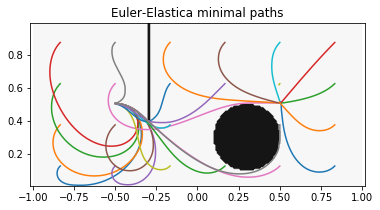

In [14]:
plt.figure(figsize=[6,3]); plt.title("Euler-Elastica minimal paths"); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1])
plt.contourf(X2,Y2,hfmIn['walls'], cmap='Greys');

One of the specified tips was located in the disk shaped obstacle. Obviously, no geodesic could be backtraced from this specific point.

In [15]:
hfmOut['geodesics'][13] # Backtracking failed since the tip was inside an obstacle. The tip alone is returned.

array([[0.16666663],
       [0.375     ],
       [0.7853982 ]], dtype=float32)

We next display the minimal geodesics from the seed (left) and unoriented seed (right), to the *unoriented* tips. These geodesics end with an arbitrary tangent at their final tip, namely the most favourable orientation in terms of energy.

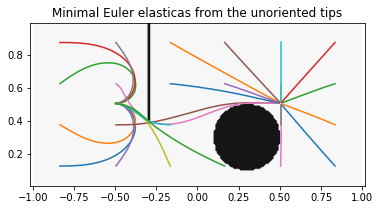

In [16]:
plt.figure(figsize=[6,3]); plt.title("Minimal Euler elasticas from the unoriented tips"); plt.axis('equal'); 
for geo in hfmOut['geodesics_Unoriented']:  plt.plot(geo[0],geo[1]) 
plt.contourf(X2,Y2,hfmIn['walls'], cmap='Greys');

The backtracked geodesics are actually three dimensional paths. In the following cell, they are shown as such, in other words their angular coordinate is not discarded. The seedpoint at the extremity of each geodesic is shown in bold. Three groups of geodesics can be distinguished
* One ending on the vertical line $(0.5,0.5,\theta)$, with an arbitrary angle $\theta$, which corresponds to the *unoriented* seed $(0.5,0.5) \in U$.
* Another one ending at the position $(-0.5,0.5,0)$, which is a prescribed seed.
* A last one ending at the position $(-0.5,0.5,2 \pi)$, which is identical to the above one once periodic boundary conditions are applied on the angular third variable $\theta\in \mathbb S^1$.

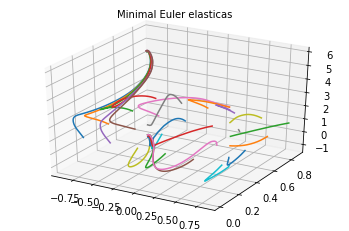

In [17]:
fig = plt.figure(); ax = fig.gca(projection='3d'); SetTitle3D(ax,"Minimal Euler elasticas")
for geodesic in hfmOut['geodesics']:
    if geodesic.shape[1]==1: continue # Eliminate the geodesic starting in an obstacle.
    plt.plot(*geodesic)
    if eikonal_mode=='cpu':ax.scatter(*geodesic[:,-1])

Finally, we present a level surface of the arrival times function $u$.

In [18]:
if useMayavi:
    mlab.contour3d(hfmOutput['values'], contours=[1])
    mlab.show() # Displays in an external window.

This is what the previous command should display.
![Solution level set](https://dl.dropbox.com/s/f0a0l64sjjy8xmd/3_Elastica_Contour3D.png?dl=0)

<!---
(https://rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/blob/master/Notebooks_FMM/Images/3_Elastica_Contour3D.png)
--->

## 4. Comparison of the different models.

In this section, we compare the qualitative features of the four main curvature penalized models implemented in the HFM library. Namely the Reeds-Shepp, Reeds-Shepp forward, Euler-Mumford elastica, and Dubins car models.


### 4.1 The Reeds-Shepp car (with reverse gear)

The classical Reeds-Shepp model is adequate for describing slow vehicles, such as wheelchairs, equipped with a reverse gear. The model belongs to the field of sub-Riemannian geometry, a generalization of Riemannian geometry involving tensors with *infinite* eigenvalues. An alternative point of view is the eikonal equation is Riemannian-like, but involves rank deficient tensors. 

The precise definition of sub-Riemannian geometry involves additional controllability assumption which are outside of the scope of this document.

In [19]:
hfmIn['model']='ReedsShepp2'
hfmIn['xi']=0.3
hfmIn['exportValues']=0
hfmIn.pop('tips_Unoriented',None);

In [20]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.07450127601623535 seconds, and 43 iterations.
Post-Processing


A distinguishing feature of the planar projections of minimal paths for the Reeds-Shepp model is the presence of *cusps*, at the points where the vehicle shifts into reverse gear.

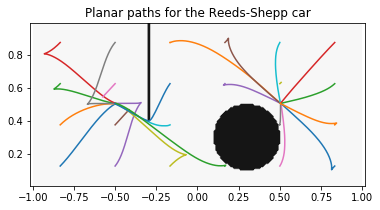

In [21]:
fig = plt.figure(figsize=[6,3]); plt.title("Planar paths for the Reeds-Shepp car"); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1])
plt.contourf(X2,Y2,hfmIn['walls'], cmap='Greys');
savefig(fig,'ReedsSheppPaths_Planar.png')

The actual three dimensional backtracked geodesics are smooth, as illustrated in the next cell. However these paths feature a vertical tangent, aligned with the angular axis, at some points. The projections of these points appear as cusps in the two dimensional representation.

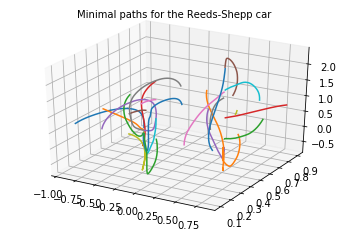

In [22]:
fig = plt.figure(); ax = fig.gca(projection='3d'); SetTitle3D(ax,"Minimal paths for the Reeds-Shepp car")
for geodesic in hfmOut['geodesics']:
    if geodesic.shape[0]==1: continue # Eliminate the geodesic starting in an obstacle.
    plt.plot(*geodesic)
    if eikonal_mode=='cpu':ax.scatter(*geodesic[:,-1])
savefig(fig,'ReedsSheppPaths.png')

Because the Reeds-Shepp car makes no distinction between the forward and the reverse gear, it makes sense to cut the angular domain in half. More precisely, we can identify opposite directions: $\theta \sim \theta + \pi$, for each angle $\theta$. 
In that case, the computation takes place on the quotiented domain
\begin{equation*}
    U \times \mathbb P^1,
\end{equation*}
where $\mathbb P^1 = \mathbb R/\pi \mathbb Z$ denotes the one-dimensional *projective* space. In other words $\mathbb P^1= [0,\pi[$ with periodic boundary conditions. 

Since the angular domain is cut in half, the number of angular directions can also be divided by two, which speeds up the computation. Note that this projective quotient makes no sense for the other models (Reeds-Shepp forward, Euler-Mumford elastica, and Dubins car) implemented in the HFM library. Indeed, they lack the reverse gear.

In [23]:
hfmIn['projective']=1. # Identify opposite orientations :  theta ~ theta + pi.
hfmIn.nTheta=nTheta # nTheta is the number of points for discretizing [0,2*pi]

In [24]:
hfmIn['dims'] # Only nTheta/2 points actually used for the angular dimension

array([200., 100.,  30.], dtype=float32)

In [25]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.07150006294250488 seconds, and 47 iterations.
Post-Processing


The geodesic backtraced from a tip $(x^*,\theta^*)\in U \times \mathbb S^1$ is sometimes identical to the one of the non-projective model, and sometimes distinct. 
Indeed, the projective model implicitly selects the shortest geodesic among those emanating from $(x^*,\theta^*)$ and from $(x^*,\theta^* +\pi)$. Interestingly, doing so tends to reduce the number of cusps.

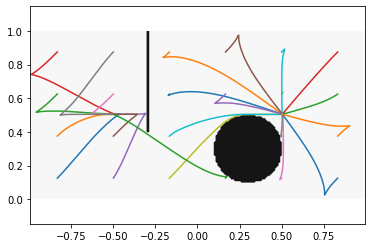

In [45]:
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1])
plt.contourf(X2,Y2,hfmIn['walls'], cmap='Greys')
plt.axis('equal');

In [27]:
# Restore the non-projective parameters.
hfmIn.pop('projective',None);
hfmIn.nTheta=nTheta

### 4.2 The Reeds-Shepp forward model (without reverse gear)

The Reeds-Shepp forward model cannot shift into reverse gear, and thus the planar projections of its paths feature no cusps. However, it has another distinguishing feature: in place rotations, without physical motion, of the car. In terms of curvature, these can be regarded as Dirac masses. They are admissible within the Reeds-Shepp forward model since the cost $\mathcal C(\kappa) := \sqrt{1+(\xi \kappa)^2}$ only grows linearly with the curvature $\kappa$.

In [28]:
hfmIn['model']='ReedsSheppForward2'
hfmIn['xi']=0.3

In [29]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.2091 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


Minimal paths for the Reeds-Shepp forward model typically feature an in-place rotation at the seed and at the tip. As a result, the tangent at these endpoints does not appear to be the prescribed one.

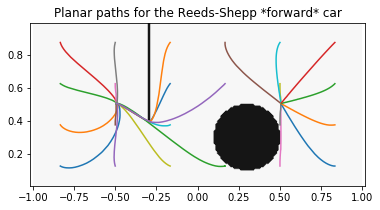

In [30]:
fig = plt.figure(figsize=[6,3]); plt.title("Planar paths for the Reeds-Shepp *forward* car"); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1])
plt.contourf(X2,Y2,hfmIn['walls'], cmap='Greys');
savefig(fig,'ReedsSheppForwardPaths_Planar.png')

In the three dimensional visualization of the paths, in place rotations appear as vertical segments, parallel with the axis of the angular coordinate $\theta$.

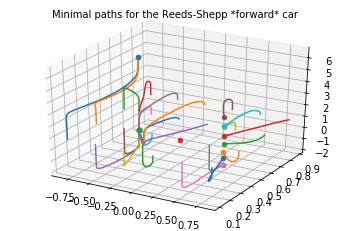

In [31]:
fig = plt.figure(); ax = fig.gca(projection='3d'); SetTitle3D(ax,"Minimal paths for the Reeds-Shepp *forward* car")
for geodesic in hfmOut['geodesics']:
    if geodesic.shape[0]==1: continue # Eliminate the geodesic starting in an obstacle.
    ax.plot(*geodesic)
    ax.scatter(*geodesic[:,-1])
savefig(fig,'ReedsSheppForwardPaths.png')

### 4.3 Euler-Mumford elastica curves

Minimal paths for this model are smooth, and have a "natural feel", since they are related to the equilibrium rest positions of an elastic bar. Computation time is slightly longer than for the Reeds-Shepp models, due to the larger stencils involved.

In [32]:
hfmIn['model']='Elastica2'
hfmIn['xi']=0.2

In [33]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 7.25125 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


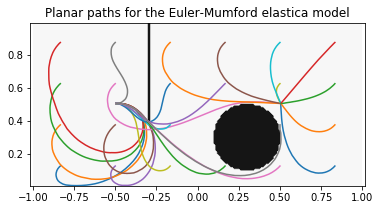

In [34]:
fig = plt.figure(figsize=[6,3]); plt.title("Planar paths for the Euler-Mumford elastica model"); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1])
plt.contourf(X2,Y2,hfmIn['walls'], cmap='Greys')
plt.axis('equal');
savefig(fig,'EulerElasticaPaths_Planar.png')

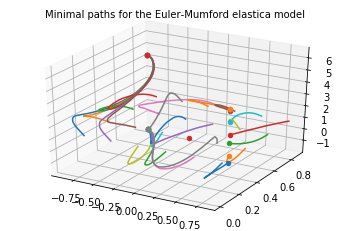

In [35]:
fig = plt.figure(); ax = fig.gca(projection='3d'); SetTitle3D(ax,"Minimal paths for the Euler-Mumford elastica model")
for geodesic in hfmOut['geodesics']:
    if geodesic.shape[0]==1: continue # Eliminate the geodesic starting in an obstacle.
    ax.plot(*geodesic)
    ax.scatter(*geodesic[:,-1])
savefig(fig,'EulerElasticaPaths.png')

### 4.4 The Dubins car

The Dubins car model features a hard constraint: the radius of curvature of admissible paths must be bounded by the value $\xi$ prescribed by the user. 

In [18]:
hfmIn['model']='Dubins2'
hfmIn['xi']=0.2

In [37]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 2.93408 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


Arguments from control theory show that the minimal geodesic paths are the concatenations of straight lines, and of arcs of circles of radius $\xi$. This qualitative property seems to be satisfied by the backtracked geodesics, although it is in no way directly encoded in the HFM software.

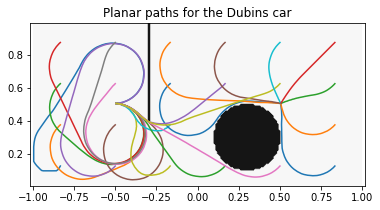

In [38]:
fig = plt.figure(figsize=[6,3]); plt.title("Planar paths for the Dubins car"); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1])
plt.contourf(X2,Y2,hfmIn['walls'], cmap='Greys');
savefig(fig,'DubinsPaths_Planar.png')

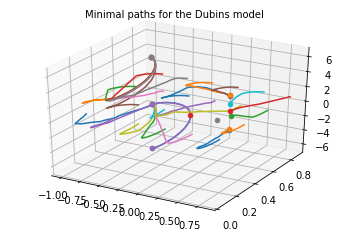

In [39]:
fig = plt.figure(); ax = fig.gca(projection='3d'); SetTitle3D(ax,"Minimal paths for the Dubins model")
for geodesic in hfmOut['geodesics']:
    if geodesic.shape[0]==1: continue # Eliminate the geodesic starting in an obstacle.
    ax.plot(*geodesic)
    ax.scatter(*geodesic[:,-1])
savefig(fig,'DubinsPaths.png')

<a name="BadGeodesics"></a>
The attentive reader will however note the presence of two geodesics, among the 24 extracted, that clearly *fail* the  curvature bound constraint. These geodesics correspond to particularly difficult configurations, and two different reasons for failure can be identified. 
* The first incorrect path (blue) ends at a tip, located in a corner of the domain, that is mathematically *unreachable*. In other words, there is no path reaching this point from the seeds and which radius of curvature is bounded by the prescribed constant $\xi$. A better answer, from the HFM library, would be not to backtrack anything in this case. 
* The second incorrect path (green) slightly violates the imposed curvature bound. An admissible path exists, but it is quite long and convoluted. Because the non-holonomy constraint numerically implemented by penalization, the HFM library did not detect it and selected this erroneous path instead. 

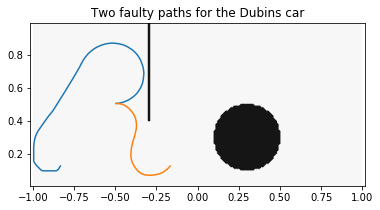

In [40]:
plt.figure(figsize=[6,3]); plt.title("Two faulty paths for the Dubins car"); plt.axis('equal'); 
geodesics = hfmOut['geodesics']
for geo in [geodesics[0],geodesics[8]]:  plt.plot(geo[0],geo[1])
plt.contourf(X2,Y2,hfmIn['walls'], cmap='Greys');

In the next experiment, we cut the relaxation parameter $\varepsilon$ in half, and we double the physical and angular grid scales, so as to better enforce the non-holonomy constraint. The blue path, leading to an unreachable tip, is eliminated as desired. The green path, formerly violating the curvature bound, is replaced with the adequate optimal admissible path.

The increased grid dimensions, by a factor 2 in each of the three dimensions, however lead to an increase in time and memory complexity, by a factor $2^3=8$.
Adressing the above issues with less computational overhead will be the object of future work, by enhancing the numerical scheme with e.g. anti-diffusive techniques.

In [21]:
hfmIn2=hfmIn.copy()
hfmIn2.update({
    'dims':2*hfmIn['dims'],
    'eps':0.05,
    'gridScale':hfmIn['gridScale']/2
})
X2_2,Y2_2,_ = hfmIn2.Grid()
X2_2,Y2_2 = X2_2[:,:,0],Y2_2[:,:,0],
hfmIn2['walls']= np.logical_or((X2_2-0.3)**2 + (Y2_2-0.3)**2 <= 0.2**2,
                                np.logical_and(X2_2==X2_2[2*70,0], Y2_2>=0.4)) 

In [22]:
%%time
hfmOut = hfmIn2.Run() # Warning : takes up to a minute.

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 34.3109 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
CPU times: user 60.4 ms, sys: 82.7 ms, total: 143 ms
Wall time: 35.5 s


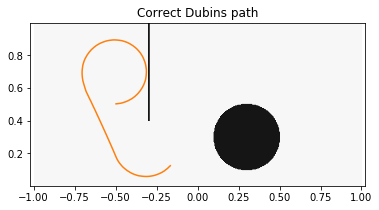

In [23]:
plt.figure(figsize=[6,3]); plt.title("Correct Dubins path"); plt.axis('equal'); 
geodesics = hfmOut['geodesics']
for geo in [geodesics[0],geodesics[8]]:  plt.plot(geo[0],geo[1])
plt.contourf(X2_2,Y2_2,hfmIn2['walls'], cmap='Greys');

## 5. Varying the cost function

The cost function $c : \Omega = U \times \mathbb S^1 \to ]0,\infty[$ is arbitrary and chosen by the user. We  considered a constant cost in the previous experiments, but a cost depending on the spatial coordinate, the angular coordinate, or both, is equally possible, as illustrated in the following experiments.


### 5.1 Cost depending on the physical position

In the next cell, the cost of motion is doubled in the lower half of the domain. Therefore, as we check numerically, minimal geodesics tend to avoid this region as much as possible.

In [24]:
hfmIn['model']='Elastica2'
hfmIn['cost'] = 1+(Y2<0.5)

In [26]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 6.29275 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


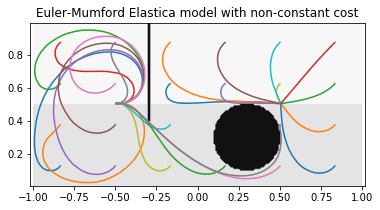

In [28]:
fig = plt.figure(figsize=[6,3]); plt.title("Euler-Mumford Elastica model with non-constant cost"); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1])
plt.contourf(X2,Y2,hfmIn['walls']+0.1*hfmIn['cost'], cmap='Greys')
savefig(fig,'Elastica_PositionDependentCost.png')

### 5.2 Orientation dependent speed

We choose to model a sail-boat as a Reeds-Shepp forward car, with a speed depending on the current orientation relative to the wind.

In [36]:
hfmIn['model']='ReedsSheppForward2'
hfmIn2=hfmIn.copy()
for key in ('cost','walls','seeds_Unoriented','seedValues_Unoriented'): 
    hfmIn2.pop(key,None)

More precisely, we assume that going directly against the wind is extremely slow, but that going sideways is much faster, as expressed by the following (synthetic) speed function. Wind comes from the right.

Recall that *speed*, as an input field to the HFM library, is nothing else than the reciprocal of *cost*. 

In [37]:
hfmIn2['speed'] = 2-np.cos(2*Theta2)-0.4*np.cos(3*Theta2) #Speed function. speed = 1/cost.

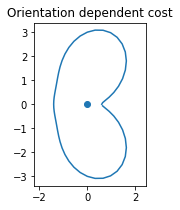

In [38]:
fig = plt.figure(figsize=[2,3]); plt.title("Orientation dependent cost"); plt.axis('equal'); 
plt.scatter(0,0); # Polar plot of the speed function
plt.plot(hfmIn2['speed']*np.cos(Theta2),hfmIn2['speed']*np.sin(Theta2));
savefig(fig,'OrientationDependentCost.png')

In [39]:
hfmOut = hfmIn2.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.664983 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


We illustrate in the next cell the minimal path from the seed to the various tips. Interestingly, this path is far from straight, dispite the lack of obstacles and the fact that the cost function does not depend on the physical position.
Indeed, the minimal geodesic goes in zig-zags from the seed (on the left) to the tips that are the right. In the context of sailboating, this is called *tacking*, and is what an actual sailboat would do.

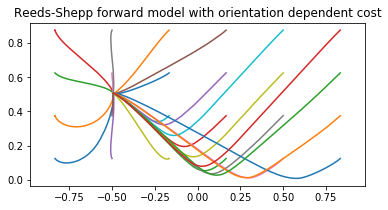

In [40]:
fig = plt.figure(figsize=[6,3]); plt.title("Reeds-Shepp forward model with orientation dependent cost"); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1])
savefig(fig,'ReedsSheppForward_OrientationDependentCost.png')

## 6. Generalized models with non-uniform curvature penalization

The classical Reeds-Shepp, Reeds-Shepp forward, Euler-Mumford elastica and Dubins models penalize curvature in a uniform and fixed manner: penalization is the same for right turns and left turns, and it does not depend on the current position. This section is devoted to generalized models, which lift this restriction.

For any point $(x,\theta) \in \Omega$, and any tangent vector $(\dot x, \dot \theta)\in \mathbb R^2 \times \mathbb R$ with physical velocity $\dot x = (\cos \theta, \sin \theta)$, one defines
\begin{equation*}
    F_{(x,\theta)} (\dot x, \dot \theta) = c(x,\theta)\,  \mathcal C\big( \, \xi(x,\theta) (\dot \theta-\kappa(x,\theta) \, \big).
\end{equation*}
The fields $\xi : \Omega\to ]0,\infty[$ and $\kappa : \Omega \to \mathbb R$ are free and provided by the user. The first field, $\xi$, locally determines the magnitude of curvature penalization. The second field, $\kappa$, is used to break the symmetry between the right and left turns, if needed. These two fields be constant, depend on the physical position, the angular orientation, or both.

As before, the metric $F$ is extended by $1$-positive homogeneity, and defined as $+\infty$ where $\dot x$ is not (positively) colinear with $(\cos \theta, \sin \theta)$. In addition, he colinearity constraint relaxed to $\dot x = \pm (\cos \theta, \sin \theta)$ in the case of the Reeds-Shepp model with reverse gear.

These less common models are provided in a different executable. The memory usage of this implementation is slightly larger than for the usual models, because we cannot exploit any redundancy in the discretization stencils.

### 6.1 Position dependent radius of curvature

In this experiment, we consider a Dubins car, subject to different bounds on the radius of curvature depending on depending on the domain region. Namely $\xi=0.2$ on the lower part of the domain, and $\xi=0.1$ on the upper part.

In [41]:
# Extended models are ReedsSheppExt2, ReedsSheppForwardExt2, ElasticaExt2<5>, and DubinsExt2
hfmIn.update({
    'model':'DubinsExt2',
    'cost':1,
    'xi': 0.1*(1+(Y2<0.5)), # Now the radius of curvature xi can be a field.
    'kappa':0,
})

In [42]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 4.62514 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


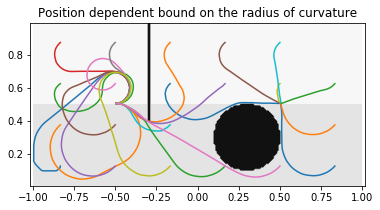

In [43]:
fig = plt.figure(figsize=[6,3]); plt.title("Position dependent bound on the radius of curvature"); plt.axis('equal'); 
for geo in hfmOut['geodesics'][:-1]:  plt.plot(geo[0],geo[1])
plt.contourf(X2,Y2,hfmIn['walls']+hfmIn['xi'], cmap='Greys');
savefig(fig,'Dubins_RadiusPositionDependent.png')

### 6.2 Distinct bound on the radius of curvature for right and left turns.

We consider a Dubins car subject to a distinct turning radius on the right and on the left.
Let us say $\xi_L$ on the left, and $\xi_R$ on the right. In order to simulate this model using the HFM software, we must reformulate our constraint in terms of the parameters $\xi$ and $\kappa$. 
\begin{equation*}
    \dot \theta \in [\xi_L,\xi_R] \quad \Leftrightarrow \quad \xi |\dot \theta-\kappa| \leq 1
\end{equation*}
Solving this system, we obtain
\begin{align*}
    \frac 1 \xi &= \frac 2 {\frac 1 {\xi_L}+\frac 1 {\xi_R}} &
    \kappa = \frac 1 2 (\frac 1 {\xi_L}-\frac 1 {\xi_R})
\end{align*}

In [44]:
# Extended models are ReedsSheppExt2, ReedsSheppForwardExt2, ElasticaExt2<5>, and DubinsExt2
xiL, xiR = 0.12,0.2
hfmIn.update({
    'model':'DubinsExt2',
    'cost':1,
    'xi':2/(1/xiL+1/xiR),
    'kappa':0.5*(1/xiL-1/xiR),
})

In [45]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 4.73432 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


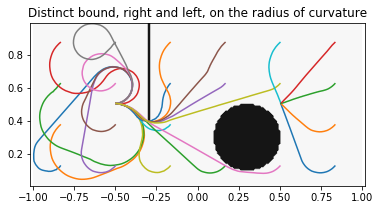

In [46]:
fig = plt.figure(figsize=[6,3]); plt.title("Distinct bound, right and left, on the radius of curvature"); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1])
plt.contourf(X2,Y2,hfmIn['walls'], cmap='Greys')
savefig(fig,'Dubins_RadiusSideDependent.png')

In [47]:
hfmIn.pop('kappa',None)

1.666666666666667

## 7. Additional functionality

We briefly describe some functionalities of the HFM software that combine particularly well with the curvature penalized models, altough they are not specific to them.

### 7.1 Euclidean length of geodesics

In this experiment, we simultaneously propagate the fast marching front, and compute the euclidean length of the corresponding minimal paths. This is done at runtime, and this euclidean length can be used as a stopping criterion.
By (generalized) Euclidean length of the path $\gamma : [0,1] \to \Omega$, we refer to the quantity defined as 
\begin{equation*}
    L_D(\gamma) := \int_0^1 \| D(\gamma(t)) \, \gamma'(t) \| \, \mathrm d t,
\end{equation*}
where $D : \Omega \to \mathbb R_+^d$ is a given field of diagonal matrices, usually chosen constant over the domain. The user provides this field by defining the *euclidean scale* of the grid for each direction of the domain.

We choose for illustration the most natural case of the constant field $D_0 \equiv \mathrm{diag}(1,1,0)$, which ignores the angular coordinates. Hence for any orientation lifted path $\gamma=(x,\theta) : [0,1] \to \mathbb R^2 \times \mathbb S^1$ one has
\begin{equation*}
    L_{D_0}(x,\theta) := \int_0^1 \|x'(t)\| \, \mathrm d t.
\end{equation*}

In [14]:
# Define the field $D : \Omega \to \mathnbb R_+^d$ 
gridScale = hfmIn['gridScale'] # ! Do not forget to take the discretization grid scale into account.
hfmIn.update({
    'euclideanScale':[gridScale,gridScale,0],
    'exportEuclideanLengths':0., # Not needed here. Defaults to 1.

    # Optionally, set a stopping criterion.
    'stopAtEuclideanLength':1.4,

    # Other model parameters
    'model':'Elastica2',
    'cost':1,
    'xi':0.2,
})

In [15]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 4.52769 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
Field euclideanLength_exportGeodesicFromStoppingPoint defaults to 1


In the next cell, we display the point that triggered the termination criterion. This is the closest point to the seeds for which the euclidean length of the corresponding minimal path exceeds our stopping criterion. We next display that geodesic.

In [16]:
hfmOut['euclideanLength_stoppingPoint']

array([0.605     , 0.395     , 1.15191731])

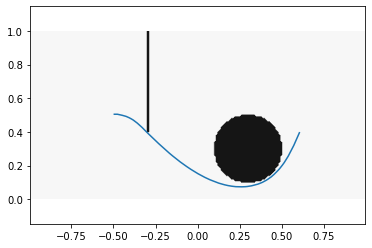

In [17]:
geo = hfmOut['geodesic_euclideanLength']
plt.plot(geo[0],geo[1])
plt.contourf(X2,Y2,hfmIn['walls'], cmap='Greys')
plt.axis('equal');

Since the front propagation was aborted early, due to the chosen stopping criterion, it has not reached all the provided geodesic tips. Therefore, some of the corresponding minimal paths could not be backtraced. This is in particular the case in the left part of the domain, where the tips and seed configuration (both oriented) lead to paths that are either long or have high curvature. 

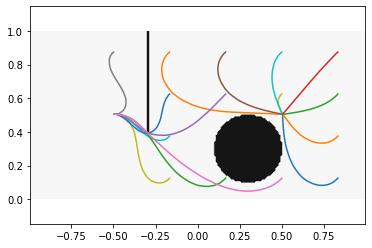

In [18]:
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1])
plt.contourf(X2,Y2,hfmIn['walls'], cmap='Greys')
plt.axis('equal');

We introduced the Reeds-Shepp and Reeds-Shepp forward using the concept of curvature penalization. However, they can also be regarded as standard euclidean models on the manifold $\mathbb R^2 \times \mathbb S^1$, subject to non-holonomic constraints. As a result, the intrinsic and euclidean lengths of the geodesics coincide.

In [20]:
gridScale = hfmIn['gridScale']
bundleScale = 2.*np.pi/nTheta

hfmIn.update({
    'model':'ReedsShepp2',
    'cost':1,
    'xi':0.3,

    'seedValue_Unoriented':0,

    # Define the field $D : \Omega \to \mathnbb R_+^d$ 
    'euclideanScale':[gridScale,gridScale, hfmIn['xi']*bundleScale ],
    'exportEuclideanLengths':1,
    'exportValues':1,
})
hfmIn.pop('stopAtEuclideanLength',None);

In [21]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field projective defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.85557 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


The announced equality, of the intrinsic and euclidean lengths, is only approximate numerically, due to our relaxation procedure. The error difference is a reasonable 5% in the Reeds-Shepp forward case. However, an almost 13% error is observed for the standard Reeds-Shepp model, due to the difficult singularities around cusps. Future improvements to the numerical code may reduce this gap.

In [22]:
values, lengths, walls = hfmOut['values'].copy(), hfmOut['euclideanLengths'].copy(), hfmIn['walls']
values[walls]=0.; lengths[walls]=0.;
print("Maximal geodesic euclidean length : ", np.max(lengths), 
      ". Difference with value function : ", np.max(np.abs(values-lengths)) )

Maximal geodesic euclidean length :  1.254374353480996 . Difference with value function :  0.314757014571014


In [23]:
hfmIn['model']='ReedsSheppForward2'
hfmOut = hfmIn.Run()
values, lengths = hfmOut['values'].copy(), hfmOut['euclideanLengths'].copy()
values[walls]=0.; lengths[walls]=0.;
print("Maximal geodesic euclidean length : ", np.max(lengths), 
      ". Difference with value function : ", np.max(np.abs(values-lengths)) )

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.913769 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
Maximal geodesic euclidean length :  1.6800942852822396 . Difference with value function :  0.6626059390420389


In the next cells, we make a similar comparison for the Dubins model. Recall that length of a path, according to this model, is the Euclidean length if the constraint on the radius of curvature is met, and $+\infty$ otherwise. 

A mismatch, between the value function $u$ and euclidean length of the corresponding minimal geodesics, is nevertheless in some locations, due to the strong singularities of this model. More precisely, this happens:
* where the distance function is discontinuous, e.g. the the boundary of some circular arcs.
* on the boundary of unreachable sets, e.g. at distance $\leq \xi$ from the left wall, for the slice $\{\theta=0\}$.

In [24]:
hfmIn['model']='Dubins2'
hfmIn['euclideanScale'] = [gridScale,gridScale, 0.]
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 2.11442 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


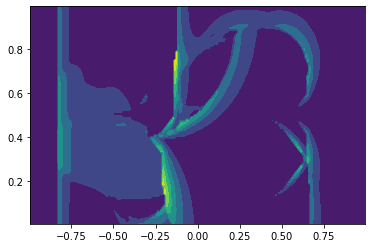

In [25]:
values, lengths = hfmOut['values'].copy(), hfmOut['euclideanLengths'].copy()
far = values>=4
values[far]=0; lengths[far]=0;
plt.contourf(X2,Y2,(values-lengths)[:,:,0]);

In [26]:
# Restore parameters
hfmIn.pop('euclideanScale',None)
hfmIn.pop('exportEuclideanLengths',None)
hfmIn.pop('seedsUnoriented',None); #hfmInput['seedsUnoriented']=[0.3]

### 7.2 Minimal geodesic joining two seeds.

In this experiment, we compute some Voronoi regions, and stop the computation as soon as two distinct regions denoted $V_0$ and $V_1$ contain *opposite* points, w.r.t. the angular coordinate. In other words as soon as a point $(x,\theta)\in \Omega$ is found such that
\begin{align*}
    (x,\theta) & \in V_0 &
    (x,\theta+\pi) & \in V_1.
\end{align*}
By doing so, we can extract a minimal geodesic joining the seed points associated with these two Voronoi regions. In addition, this criterion tends to stop the fast marching algorithm rather early, when it is only propagated on a small portion of the domain, which may substantially reduce computation time.

In [11]:
# Voronoi diagram data
hfmIn.update({
    'seedFlag':0, # Use 'seedFlags' in case of several seeds
    'seedFlag_Unoriented':1, # Likewise
    'exportVoronoiFlags': 0, # No need to export the Voronoi diagram here
    
    # Voronoi stopping criterion : when a region contains (x,theta) and the other (x,theta+pi)
    'voronoiStoppingCriterion':'OppositesMeeting',

    # Other model parameters
    'model':'Dubins2',
    'cost':1,
    'xi':0.2,
})

In [12]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.261878 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
Field voronoiDiagram_exportGeodesicFromMeetingPoint defaults to 1


The meeting point is returned, as well as the minimal geodesic to each of the seeds.

In [13]:
print(hfmOut['voronoiDiagram_meetingPoint0'], " is opposite to ", hfmOut['voronoiDiagram_meetingPoint1'])

[0.115      0.475      0.41887902]  is opposite to  [0.115      0.475      3.56047167]


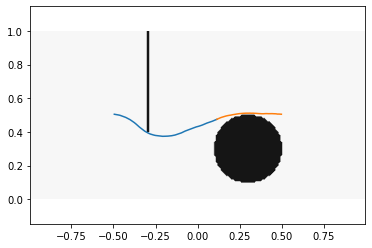

In [16]:
for geo in hfmOut['geodesics_voronoiDiagram']:  plt.plot(geo[0],geo[1])
plt.contourf(X2,Y2,hfmIn['walls'], cmap='Greys')
plt.axis('equal');

Since the fast marching algorithm was aborted early, only a few geodesics from the other seeds can be backtraced.

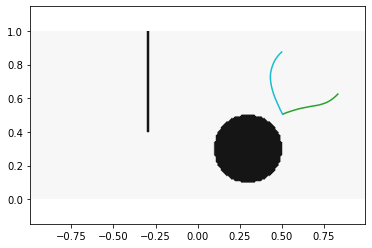

In [17]:
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1])
plt.contourf(X2,Y2,hfmIn['walls'], cmap='Greys')
plt.axis('equal');

In the previous experiments involving Voronoi regions, in the context of Isotropic or Riemannian metrics, we considered another stopping criterion : stop as soon as a point $(x,\theta)$ common to the two Voronoi regions is found. This criterion, while it may seem natural, is completely inadequate for curvature penalized models. The next cells illustrate numerically what happends.

In [18]:
hfmIn['voronoiStoppingCriterion']='RegionsMeeting'

In [19]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.563178 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
Field voronoiDiagram_exportGeodesicFromMeetingPoint defaults to 1


The voronoi regions first meet at the following neighbord point on the discretization grid.

In [20]:
print(hfmOut['voronoiDiagram_meetingPoint0'], " is (almost) the same as ", hfmOut['voronoiDiagram_meetingPoint1'])

[0.065      0.665      1.78023584]  is (almost) the same as  [0.065      0.665      1.88495559]


However the geodesics from this meeting point, backtraced to the seeds, do not form a global geodesic when concatenated. A cusp is observed instead. This is due to the asymmetry of the metrics involved in curvature penalization.

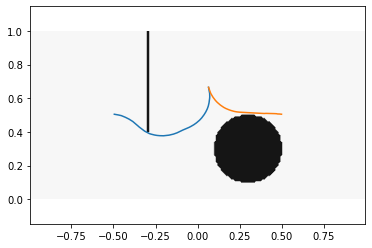

In [21]:
for geo in hfmOut['geodesics_voronoiDiagram']:  plt.plot(geo[0],geo[1])
plt.contourf(X2,Y2,hfmIn['walls'], cmap='Greys')
plt.axis('equal');